# 🧱 Modifying the DCGAN - Bricks Data

This is an attempt to modify the book generative deep learning's DCGANS section

In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from utils import display, sample_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [9]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 1. Prepare the data <a name="prepare"></a>

In [10]:
train_data = utils.image_dataset_from_directory(
    "/home/build_2024/Desktop/Generative_Deep_Learning_2nd_Edition/notebooks/04_gan/01_dcgan/Data_sets/dataset",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files.


In [11]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [12]:
train_sample = sample_batch(train)

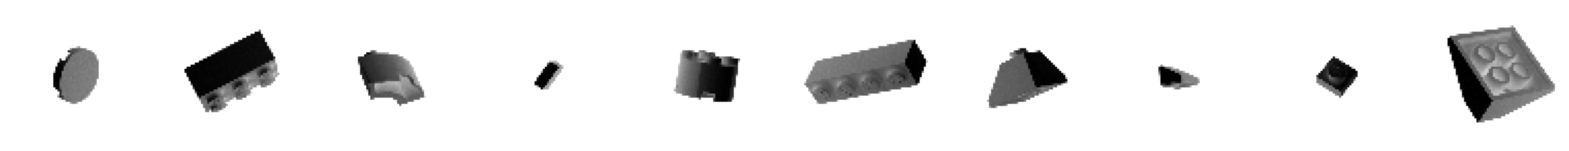

In [13]:
display(train_sample)

In [14]:
train_sample.shape

(128, 64, 64, 1)

## 2. Build the GAN <a name="build"></a>

In [16]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="linear",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 512)      │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 1, 1, 1)        │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761,728 (10.54 MB)

 Trainable params: 2,761,728 (10.54 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
generator_input = layers.Input(shape=(Z_DIM,)) #1
x = layers.Reshape((1, 1, Z_DIM))(generator_input) #2
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x) #3
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x) #4
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 512)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 1)      │         1,024 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,576,576 (13.64 MB)

 Trainable params: 3,574,656 (13.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [19]:
class WGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
    
    #@tf.function
    def discriminator_loss_fn(self,real_img,fake_img):
        real_loss = tf.reduce_mean(self.discriminator(real_img))
        fake_loss = tf.reduce_mean(self.discriminator(fake_img))
        #maximizing the difference between real and fake losses
        return tf.math.negative(tf.math.subtract(real_loss, fake_loss, name="Discriminator_loss"))    
    
    #@tf.function
    def generator_loss_fn(self,fake_img):
        return tf.math.negative(tf.reduce_mean(self.discriminator(fake_img)))

    #@tf.function
    def gradient_penalty(self,real_images, fake_images, batch_size):
        # Alpha: random mixing factor
        alpha = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0., maxval=1.)
    
        # Interpolated images
        interpolated_images = alpha * real_images + (1 - alpha) * fake_images
    
        with tf.GradientTape() as tape:
            # Tells TensorFlow to watch the interpolated images
            tape.watch(interpolated_images)
            # Pass interpolated images through discriminator
            predictions = self.discriminator(interpolated_images)
        
        # Calculate the gradients with respect to the interpolated images
        gradients = tape.gradient(predictions, interpolated_images)
    
        # Calculate the L2 norm of the gradients
        gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    
        # Gradient penalty
        gradient_penalty = tf.reduce_mean(tf.square(gradients_norm - 1.0))
    
        return gradient_penalty
        
    #rework
    def compile(self, d_optimizer, g_optimizer):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        #self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        #self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    #@property
    #def metrics(self):
        #return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        ) 

        # Train the discriminator, the book suggested every 3-5 steps of discriminator training then 1 step of generator training
        for I in range(3):
            with tf.GradientTape() as disc_tape:
                generated_images = self.generator(random_latent_vectors, training=False)
                discriminator_loss = self.discriminator_loss_fn(real_images,generated_images) + self.gradient_penalty(real_images,generated_images, batch_size)
                gradients_of_discriminator = disc_tape.gradient(
                    discriminator_loss, self.discriminator.trainable_variables
                )
                self.d_optimizer.apply_gradients(
                    zip(gradients_of_discriminator, discriminator.trainable_variables)
            )

        #After 3 steps of discriminator training, I am not sure if I should generate new latent_vectors, I assume since we trained the discriminator with this noise batch we should
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as gen_tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            generator_loss = self.generator_loss_fn(generated_images)
            gradients_of_generator = gen_tape.gradient(generator_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(
                zip(gradients_of_generator, generator.trainable_variables)
            )
        # Metrics are now reduced
        #self.d_loss_metric.update_state(total_d_loss)
        #self.g_loss_metric.update_state(g_loss)
        return {
        "d_loss": discriminator_loss,  # Discriminator loss, Discriminator loss
        "g_loss": generator_loss}

In [20]:
# Create a DCGAN
Wgan = WGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [21]:
LOAD_MODEL = False
if LOAD_MODEL:
    Wgan.load_weights("./checkpoint/checkpoint.weights.h5")

## 3. Train the GAN <a name="train"></a>

In [22]:
Wgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [23]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/WGAN_checkpoint.weights.h5",  # Changed to a relative path
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

Epoch 1/300


I0000 00:00:1714117932.190876    5517 service.cc:145] XLA service 0x7dbb1c095ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714117932.190906    5517 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-04-26 00:52:12.282710: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1714117932.351123    5517 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
2024-04-26 00:52:12.592400: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  2/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - d_loss: -2.6263 - g_loss: -0.5069

I0000 00:00:1714117935.574387    5517 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - d_loss: -111.8294 - g_loss: -143.3200
Saved to ./output/generated_img_000.png


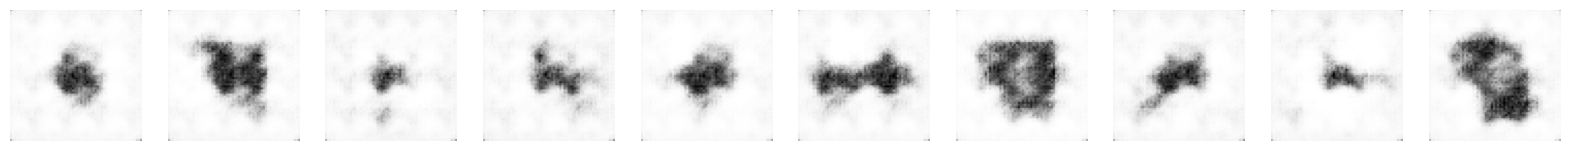

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - d_loss: -111.8294 - g_loss: -143.3200 - loss: 0.0000e+00
Epoch 2/300
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - d_loss: -8.0011 - g_loss: -74.1254
Saved to ./output/generated_img_001.png


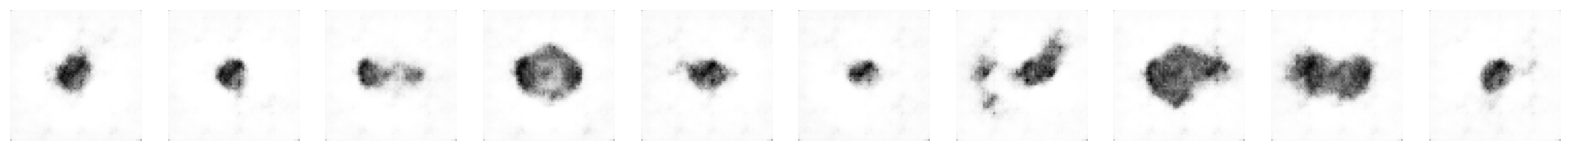

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - d_loss: -7.9975 - g_loss: -74.1738 - loss: 0.0000e+00
Epoch 3/300
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: -6.2943 - g_loss: -46.0999
Saved to ./output/generated_img_002.png


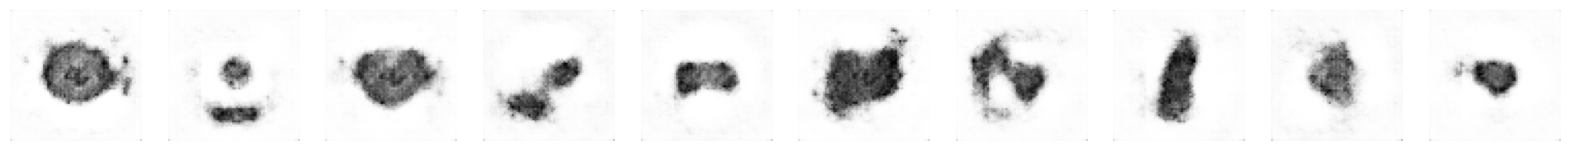

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - d_loss: -6.2951 - g_loss: -46.2065 - loss: 0.0000e+00
Epoch 4/300
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: -5.3326 - g_loss: -38.4888
Saved to ./output/generated_img_003.png


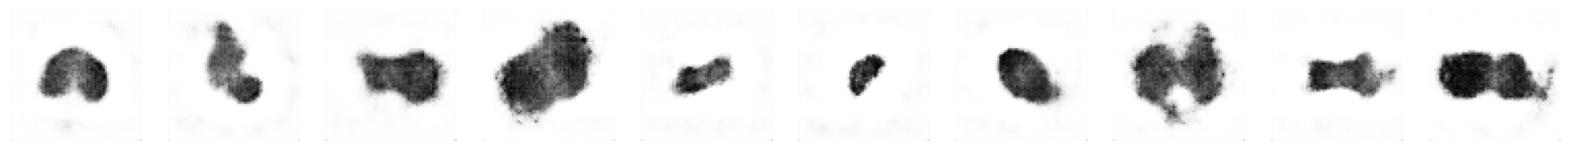

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - d_loss: -5.3285 - g_loss: -38.3434 - loss: 0.0000e+00
Epoch 5/300
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - d_loss: -4.9290 - g_loss: -35.7135
Saved to ./output/generated_img_004.png


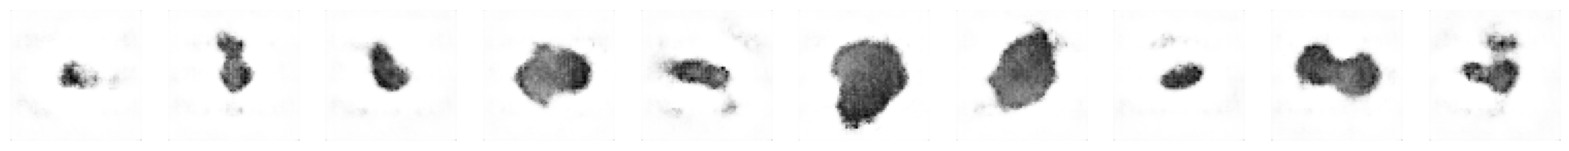

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - d_loss: -4.9276 - g_loss: -35.6715 - loss: 0.0000e+00
Epoch 6/300
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: -4.1562 - g_loss: -31.7169
Saved to ./output/generated_img_005.png


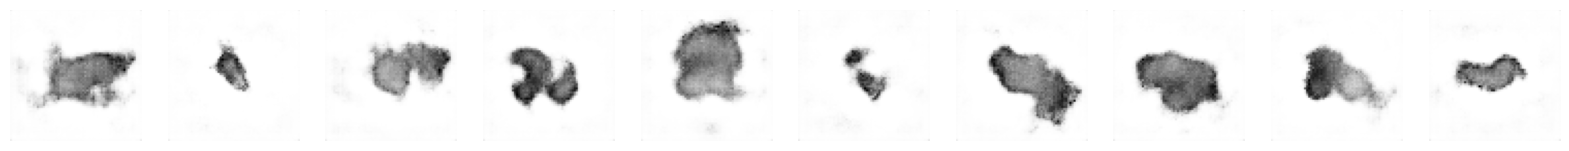

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - d_loss: -4.1557 - g_loss: -31.7904 - loss: 0.0000e+00
Epoch 7/300
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: -3.7172 - g_loss: -26.4006
Saved to ./output/generated_img_006.png


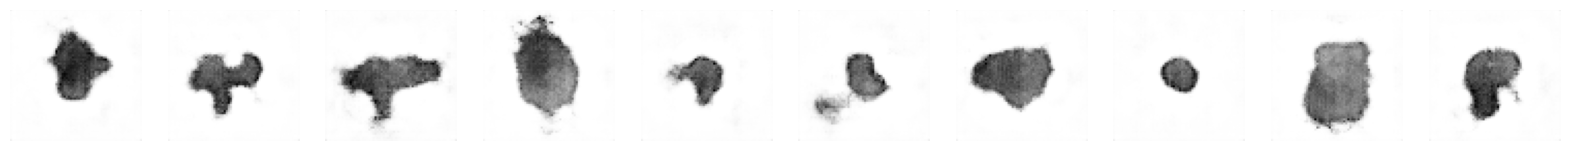

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - d_loss: -3.7155 - g_loss: -26.4199 - loss: 0.0000e+00
Epoch 8/300
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - d_loss: -3.7314 - g_loss: -22.3992
Saved to ./output/generated_img_007.png


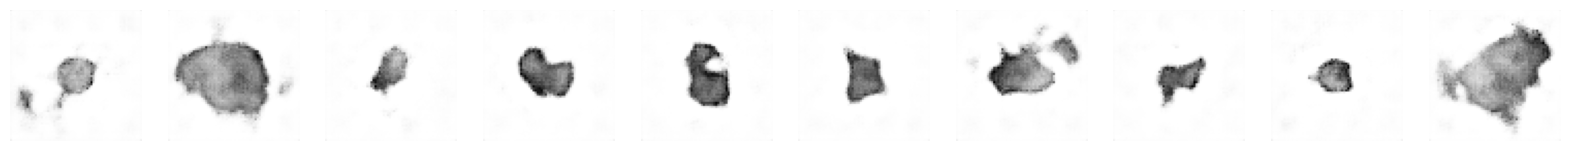

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - d_loss: -3.7381 - g_loss: -22.4522 - loss: 0.0000e+00
Epoch 9/300
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - d_loss: -3.7022 - g_loss: -18.4587
Saved to ./output/generated_img_008.png


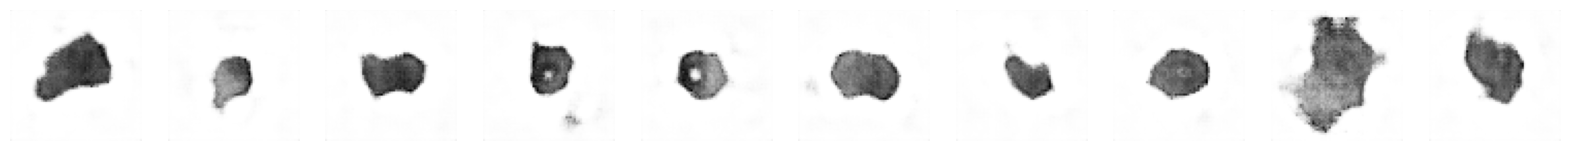

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - d_loss: -3.7060 - g_loss: -18.4372 - loss: 0.0000e+00
Epoch 10/300
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: -3.4863 - g_loss: -17.4341
Saved to ./output/generated_img_009.png


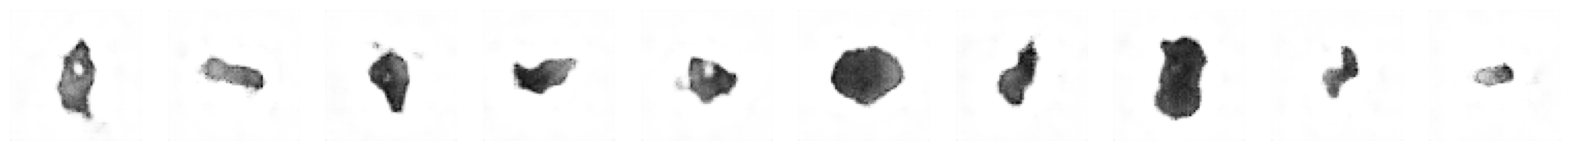

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - d_loss: -3.4871 - g_loss: -17.4397 - loss: 0.0000e+00
Epoch 11/300
185/313 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - d_loss: -3.5347 - g_loss: -14.7238

In [ ]:
Wgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [ ]:
# Save the final models
generator.save("./models/generator")
discriminator.save("./models/discriminator")

## 3. Generate new images <a name="decode"></a>

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [ ]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [ ]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

In [ ]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

In [ ]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()